Load packages

In [195]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
import sklearn.model_selection as cv

import gensim
from gensim.models import Word2Vec 
from gensim.models import word2vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction import DictVectorizer

import re
from nltk.corpus import stopwords

from sklearn.manifold import TSNE
%matplotlib inline

from wordcloud import WordCloud

#from textblob import TextBlob


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer



## Initial data exploration and cleaning

#### Load data and take a look at what the data looks like

In [196]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [197]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [198]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


#### Evaluate nulls

It looks like keyword and location both have many nulls. Keyword might not be relevant anyways becuase we'll vectorize the data anyways. Location may have too many nulls to helpful, additionally, the text shows mentions of locations that are not showing up in the location column (e.g. train record id 4 says La Ronge Sask Canada, but location is null)

In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [200]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.0+ KB


#### Evaluate skews in target variable

Data is slightly skewed but I think this should be okay without balancing

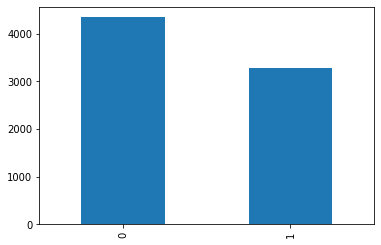

In [201]:
pd.value_counts(train['target']).plot.bar()

#### Clean text data

In [202]:
######for train data######
#lowercase
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove punctuation, special characters, keep # 
train['text'] = train['text'].str.replace('[^\w\s]','')
#remove stopwords
stop = stopwords.words('english')
train['text'] = train['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#fix spelling mistakes; commenting this out as it's taking a very long time to load complete
#train['text']=train['text'].apply(lambda x: str(TextBlob(x).correct()))

#lemmatization
from textblob import Word
train['text'] = train['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


train.head(15)

######for test data######
#lowercase
test['text'] = test['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#remove punctuation, special characters, keep # 
test['text'] = test['text'].str.replace('[^\w\s]','')
#remove stopwords
stop = stopwords.words('english')
test['text'] = test['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#fix spelling mistakes; commenting this out as it's taking a very long time to load complete
#train['text']=train['text'].apply(lambda x: str(TextBlob(x).correct()))

#lemmatization
from textblob import Word
test['text'] = test['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

Diving into numbers
In come cases (e.g. train id 16, the text version of the number is used). I'd like to set the values to be all numbers for consistency.

In [203]:
def text2int (textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

In [204]:
######for train data######
train['text'] = train['text'].apply(lambda x: text2int(x))
train.head(15)

######for test data######
test['text'] = test['text'].apply(lambda x: text2int(x))

#### Visualize the data

Visualize t-SNE representations and word clouds of the most common words. 
I'll create a separate visualization for target = 1 and target = 0 in the training data, and just one for the test data.

In [205]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus


In [206]:
corpus_train_1 = build_corpus(train[(train['target']==1) & (test['text'])])   
corpus_train_0 = build_corpus(train[(train['target']==0) & (test['text'])])   
#corpus_test = build_corpus(test['text'])
corpus_test = build_corpus(test)

In [207]:
#word2vec to produce a vocabulary, with each word being represented by an n-dimensional numpy array
model_train_1 = word2vec.Word2Vec(corpus_train_1, size=100, window=20, min_count=75, workers=4)
model_train_0 = word2vec.Word2Vec(corpus_train_0, size=100, window=20, min_count=75, workers=4)
model_test = word2vec.Word2Vec(corpus_test, size=100, window=20, min_count=75, workers=4)

In [208]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


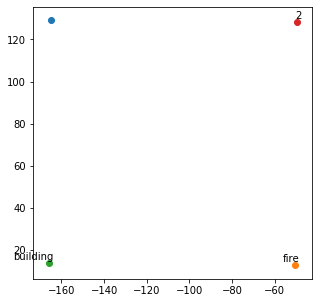

In [209]:
tsne_plot(model_train_1)

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


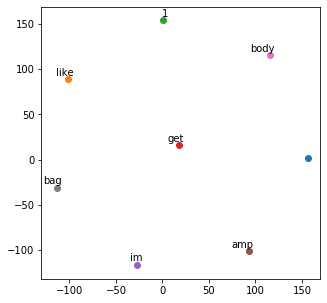

In [210]:
tsne_plot(model_train_0)

/Users/khristine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


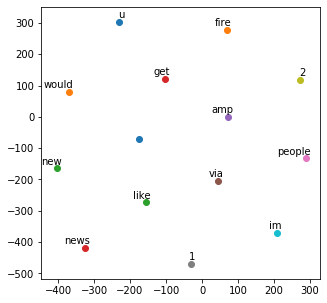

In [211]:
tsne_plot(model_test)

## Modelling the data 

Vectorize text data

In [212]:
count_vectorizer = feature_extraction.text.CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train["text"])

Run ML models on vectorized text data

In [213]:
y=train['target']
x=train_vectors
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=0.2)
SEED=1

In [214]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=1, random_state=1)
#dt = DecisionTreeClassifier(random_state = 40)
# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)


# Import accuracy_score


# Predict test set labels
y_pred = dt.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(dt, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test set accuracy: 0.58
Accuracy: -0.58 (+/- 0.01)
[-0.57471264 -0.58456486 -0.57635468 -0.57635468 -0.57881773]
[[882   0]
 [633   8]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.74       882
           1       1.00      0.01      0.02       641

    accuracy                           0.58      1523
   macro avg       0.79      0.51      0.38      1523
weighted avg       0.76      0.58      0.44      1523



In [215]:
#SVM

from sklearn.svm import SVC

svm = SVC(C=0.5, kernel='rbf')
svm.fit(x_train, y_train)

# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = svm.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(svm, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test set accuracy: 0.58
Accuracy: -0.57 (+/- 0.00)
[-0.5681445 -0.5681445 -0.5681445 -0.5681445 -0.5681445 -0.5681445
 -0.5681445 -0.5681445 -0.5681445 -0.5681445]
[[882   0]
 [641   0]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       882
           1       0.00      0.00      0.00       641

    accuracy                           0.58      1523
   macro avg       0.29      0.50      0.37      1523
weighted avg       0.34      0.58      0.42      1523



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [216]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=1)

# Fit dt to the training set
lg.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)

# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = lg.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(lg, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test set accuracy: 0.81


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: -0.79 (+/- 0.03)
[-0.79146141 -0.8045977  -0.79310345 -0.79310345 -0.77339901 -0.79474548
 -0.82430213 -0.76518883 -0.79967159 -0.79474548]
[[772 110]
 [180 461]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       882
           1       0.81      0.72      0.76       641

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [217]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, min_samples_leaf=5 )
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test set accuracy: 0.78
Accuracy: -0.76 (+/- 0.03)
[-0.78325123 -0.77996716 -0.75369458 -0.76190476 -0.73399015 -0.77504105
 -0.77339901 -0.74876847 -0.77996716 -0.75697865]
Accuracy: -0.76 (+/- 0.03)
[-0.78325123 -0.77996716 -0.75369458 -0.76190476 -0.73399015 -0.77504105
 -0.77339901 -0.74876847 -0.77996716 -0.75697865]
[[792  90]
 [243 398]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       882
           1       0.82      0.62      0.71       641

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



In [218]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train)
predictions = naive_bayes.predict(x_test)

# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(naive_bayes, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.79 (+/- 0.03)
[-0.76847291 -0.81116585 -0.79967159 -0.78325123 -0.79474548 -0.79802956
 -0.80131363 -0.77175698 -0.81280788 -0.80131363]
[[792  90]
 [243 398]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       882
           1       0.82      0.62      0.71       641

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



In [219]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(x_train, y_train)
predictions = naive_bayes.predict(x_test)

# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(xg, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.73 (+/- 0.03)
[-0.72249589 -0.74712644 -0.74384236 -0.71100164 -0.71756979 -0.73891626
 -0.72249589 -0.71592775 -0.73563218 -0.70279146]
[[792  90]
 [243 398]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       882
           1       0.82      0.62      0.71       641

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.79      0.78      0.78      1523



In [220]:
#Voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(n_estimators = 100,random_state=SEED)
naive_bayes = MultinomialNB()

# Define a list called classifier that contains
# the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rf),
('Naive Bayes', naive_bayes)]


vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set
vc.fit(x_train, y_train)
# Predict test set labels
y_pred = vc.predict(x_test)
# Evaluate the test-set accuracy of 'vc'


accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Voting Classifier: 0.817


In [221]:
# Import accuracy_score
from sklearn.metrics import accuracy_score
for clf_name, clf in classifiers:    
  
    # Fit clf to the training set
    clf.fit(x_train, y_train)    
  
    # Predict y_pred
    y_pred = clf.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
  
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.810


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


K Nearest Neighbours : 0.679
Classification Tree : 0.773
Random Forest : 0.808
Naive Bayes : 0.800


In [222]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(vc, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.79 (+/- 0.03)
[-0.78817734 -0.81444992 -0.79146141 -0.80295567 -0.77339901 -0.80623974
 -0.80295567 -0.76847291 -0.79474548 -0.80295567]
[[738 144]
 [161 480]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       882
           1       0.77      0.75      0.76       641

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



Looks like NB, voting classifier are performing the best.

## Trying the same thing but with TFIDF

In [223]:
import pandas as pd
 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
 
#instantiate CountVectorizer()
countvec=CountVectorizer()
 
# this steps generates word counts for the words in your docs
word_count_vector=countvec.fit_transform(train["text"])

In [224]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [225]:
# count matrix
count_vector=countvec.transform(train["text"])
 
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(count_vector)
 

Run ML models on vectorized text data

In [226]:
y=train['target']
x=tf_idf_vector
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=0.2)
SEED=1

In [227]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(max_depth=1, random_state=1)
#dt = DecisionTreeClassifier(random_state = 40)
# Fit dt to the training set
dt.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)


# Import accuracy_score


# Predict test set labels
y_pred = dt.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(dt, x_train, y_train, cv=5, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test set accuracy: 0.60
Accuracy: -0.59 (+/- 0.01)
[-0.57916325 -0.59277504 -0.59277504 -0.58292282 -0.57929334]
[[859  19]
 [596  49]]
              precision    recall  f1-score   support

           0       0.59      0.98      0.74       878
           1       0.72      0.08      0.14       645

    accuracy                           0.60      1523
   macro avg       0.66      0.53      0.44      1523
weighted avg       0.65      0.60      0.48      1523



In [228]:
#SVM

from sklearn.svm import SVC

svm = SVC(C=0.5, kernel='rbf')
svm.fit(x_train, y_train)

# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = svm.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))


from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(svm, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Test set accuracy: 0.58


/Users/khristine/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: -0.57 (+/- 0.00)
[-0.56885246 -0.56885246 -0.56885246 -0.56885246 -0.5681445  -0.5681445
 -0.56907895 -0.56907895 -0.56907895 -0.56907895]
[[878   0]
 [645   0]]
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       878
           1       0.00      0.00      0.00       645

    accuracy                           0.58      1523
   macro avg       0.29      0.50      0.37      1523
weighted avg       0.33      0.58      0.42      1523



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [229]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=1)

# Fit dt to the training set
lg.fit(x_train, y_train)

# Predict test set labels
#y_pred = dt.predict(x_test)

# Import accuracy_score
from sklearn.metrics import accuracy_score

# Predict test set labels
y_pred = lg.predict(x_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(lg, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Test set accuracy: 0.81
Accuracy: -0.80 (+/- 0.03)
[-0.79016393 -0.82295082 -0.80491803 -0.81311475 -0.78325123 -0.77996716
 -0.77960526 -0.78947368 -0.81085526 -0.77960526]
[[813  65]
 [228 417]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       878
           1       0.87      0.65      0.74       645

    accuracy                           0.81      1523
   macro avg       0.82      0.79      0.79      1523
weighted avg       0.82      0.81      0.80      1523



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [230]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, min_samples_leaf=5 )
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test set accuracy: 0.78
Accuracy: -0.76 (+/- 0.03)
[-0.75901639 -0.77213115 -0.77540984 -0.78196721 -0.75862069 -0.76190476
 -0.74177632 -0.75328947 -0.78618421 -0.75657895]
Accuracy: -0.76 (+/- 0.03)
[-0.75901639 -0.77213115 -0.77540984 -0.78196721 -0.75862069 -0.76190476
 -0.74177632 -0.75328947 -0.78618421 -0.75657895]
[[774 104]
 [228 417]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       878
           1       0.80      0.65      0.72       645

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [231]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train)
predictions = naive_bayes.predict(x_test)

# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(naive_bayes, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.80 (+/- 0.03)
[-0.80327869 -0.82622951 -0.79180328 -0.82131148 -0.77339901 -0.78489327
 -0.79440789 -0.78289474 -0.80756579 -0.80427632]
[[774 104]
 [228 417]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       878
           1       0.80      0.65      0.72       645

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [232]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(x_train, y_train)
predictions = naive_bayes.predict(x_test)

# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(xg, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)


print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.73 (+/- 0.04)
[-0.69180328 -0.75245902 -0.73278689 -0.75901639 -0.71756979 -0.70279146
 -0.71710526 -0.70888158 -0.75164474 -0.73190789]
[[774 104]
 [228 417]]
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       878
           1       0.80      0.65      0.72       645

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [233]:
#Voting classifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN

lr = LogisticRegression(random_state=SEED)
knn = KNN()
dt = DecisionTreeClassifier(random_state=SEED)
rf = RandomForestClassifier(n_estimators = 100,random_state=SEED)
naive_bayes = MultinomialNB()

# Define a list called classifier that contains
# the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
('K Nearest Neighbours', knn),
('Classification Tree', dt),
('Random Forest', rf),
('Naive Bayes', naive_bayes)]


vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set
vc.fit(x_train, y_train)
# Predict test set labels
y_pred = vc.predict(x_test)
# Evaluate the test-set accuracy of 'vc'


accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))



/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Voting Classifier: 0.814


In [234]:
# Import accuracy_score
from sklearn.metrics import accuracy_score
for clf_name, clf in classifiers:    
  
    # Fit clf to the training set
    clf.fit(x_train, y_train)    
  
    # Predict y_pred
    y_pred = clf.predict(x_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
  
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.808


/Users/khristine/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


K Nearest Neighbours : 0.776
Classification Tree : 0.754
Random Forest : 0.792
Naive Bayes : 0.801


In [235]:
from sklearn.model_selection import cross_val_score


# Compute the array containing the 10-folds CV MSEs
acc_CV_scores = - cross_val_score(vc, x_train, y_train, cv=10, 
                                  scoring='accuracy', 
                                  n_jobs=-1) 
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_CV_scores.mean(), acc_CV_scores.std() * 2))
print(acc_CV_scores)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy: -0.80 (+/- 0.03)
[-0.78688525 -0.8295082  -0.8        -0.80163934 -0.78817734 -0.77504105
 -0.78453947 -0.79440789 -0.80756579 -0.78947368]
[[811  67]
 [236 409]]
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       878
           1       0.86      0.63      0.73       645

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523

